In [1]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
import matplotlib.pyplot as plt
import geopy.distance as geo
from utils import read_data

In [2]:
data_file = r'data\Map_village_20241227_data.csv'

data,households,pumps,open_wells = read_data(data_file)

In [20]:
pos_households = households[['Lon','Lat']].to_numpy() # For f1 (sum of weighted distances)
nb_capita = households['Nb capita'].to_numpy() # Define weight factors for each distance in pos_households

pos_pumps = pumps[['Lon','Lat']].to_numpy() # For f2 (min distance)
initial_nb_pumps = len(pos_pumps)
cost_conversion=5000
cost_standpipe=1000
cost_per_meter=6
consumption_person=5 #L/person/day

baseline_consumption = np.zeros(len(pos_pumps))
min_distance_index = np.zeros(len(pos_households), dtype=int)

for index1, household in enumerate(pos_households):
    distances = np.zeros(len(pos_pumps))
    for index2, pump in enumerate(pos_pumps):
        distances[index2] = geo.great_circle((household[1], household[0]), (pump[1], pump[0])).meters
    min_distance_index[index1] = np.argmin(distances)
    baseline_consumption[min_distance_index[index1]] += nb_capita[index1] * consumption_person
    

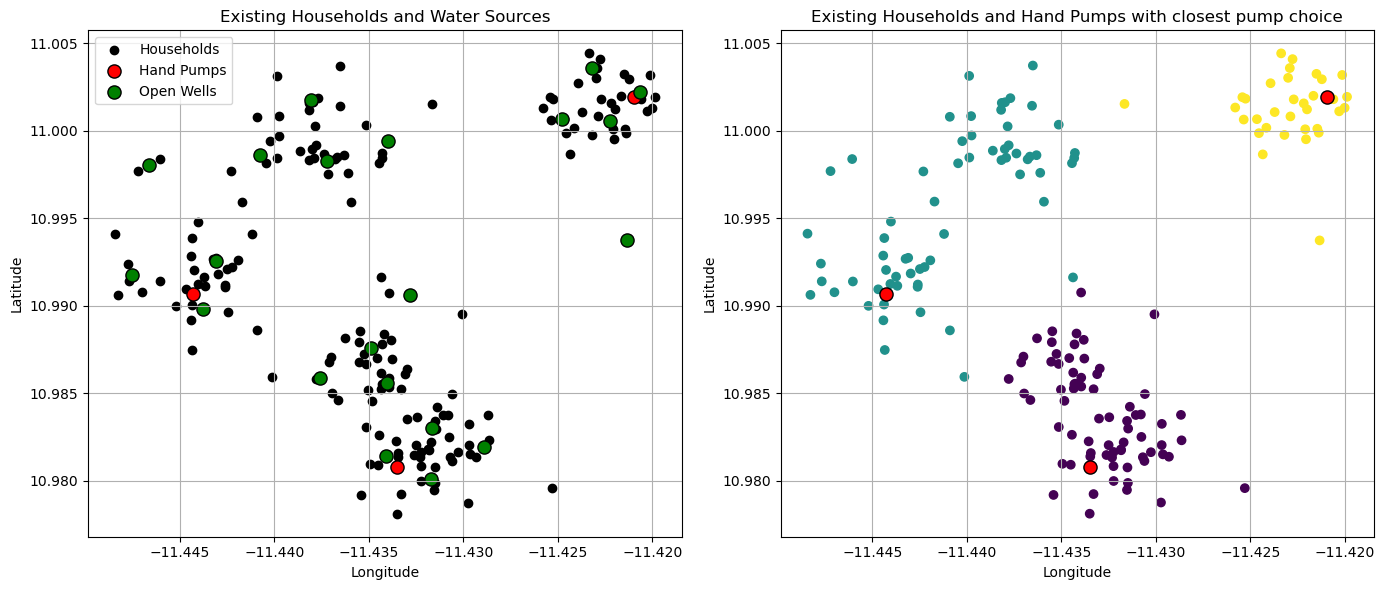

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14, 6))
# Plot households (black dots)
ax1.scatter(households['Lon'], households['Lat'], color='black', label='Households')
# Plot previous pumps (red)
ax1.scatter(pos_pumps[:, 0], pos_pumps[:, 1], color='red', label='Hand Pumps', edgecolors='k', s=90)
# Plot open wells (green)
ax1.scatter(open_wells['Lon'], open_wells['Lat'], color='green', label='Open Wells', edgecolors='k', s=90)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title(f'Existing Households and Water Sources')
ax1.legend()
ax1.grid(True)

# Ax2 Colour households by pump choice
# Plot households (black dots)
ax2.scatter(households['Lon'], households['Lat'], c=min_distance_index, label='Households')
# Plot previous pumps (red)
ax2.scatter(pos_pumps[:, 0], pos_pumps[:, 1], color='red', label='Hand Pumps', edgecolors='k', s=90)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title(f'Existing Households and Hand Pumps with closest pump choice')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [11]:
def impact(pump_positions, household_positions, household_capita, x = None):
    pump_positions_copy = pump_positions.copy()
    if isinstance(x, np.ndarray):
        pump_positions_copy = np.concatenate((pump_positions_copy,np.array([x])),axis = 0)
    min_pump_distance = np.zeros(len(household_positions))
    for index,pos_houseshold in enumerate(household_positions):
        dist = np.zeros(len(pump_positions_copy))
        for i,pump_pos in enumerate(pump_positions_copy):
            dist[i] = geo.great_circle(pump_pos, household_positions[index]).meters
        min_pump_distance[index] = np.min(dist)

    impact = np.sum(household_capita * (min_pump_distance))
    return impact

initial_impact = impact(pos_pumps,pos_households,nb_capita)


bounds = np.array([
        [data['Lon'].min(), data['Lat'].min()],  # Min bounds
        [data['Lon'].max(), data['Lat'].max()],  # Max bounds
    ])
    

class MyProblem(ElementwiseProblem):
    def __init__(self, pump_specified=None):
        super().__init__(n_var=2, n_obj=2, n_constr=1, xl=bounds[0], xu=bounds[1])  # 2D search space
        self.pump_indices = []  # Store pump indices
        self.pump_specified = pump_specified  # Specify a pump index to be fixed

    def _evaluate(self, x, out, *args, **kwargs):

        # Compute weighted sum of distances to points in pos_households
        f1 = impact(pos_pumps,pos_households,nb_capita,x)-initial_impact  # Negative impact calculation with new x location
        
        # Compute minimum distance to any point in pos_pumps
        f2_distances = np.zeros(len(pos_pumps))
        for index,pump in enumerate(pos_pumps):
            f2_distances[index] = geo.great_circle(pump, x).meters
        
        # Add penalty term if the new pump is not closest to the specified pump
        if self.pump_specified is not None:
            f2 = cost_conversion+cost_standpipe+cost_per_meter*f2_distances[self.pump_specified]
        else:
            f2 = cost_conversion+cost_standpipe+cost_per_meter*np.min(f2_distances)  # Minimum distance to any point in pos_pumps



        # Define constraint: f1 >= c
        c = initial_impact
        g1 = f1-c

        out["F"] = [f1, f2]  # Objective functions
        out["G"] = [g1]  # Constraints (must be <= 0)

    def get_final_pump_indices(self, res):
        """Retrieve pump indices for the final generation."""
        self.pump_indices = []
        if self.pump_specified is not None:
            # If a pump is specified, use its index directly
            self.pump_indices = [self.pump_specified] * len(res.X)
        else:
            # If no pump is specified, find the closest pump for each solution
            for x in res.X:  # Iterate over the final generation's solutions
                f2_distances = np.zeros(len(pos_pumps))
                for index, pump in enumerate(pos_pumps):
                    f2_distances[index] = geo.great_circle(pump, x).meters
                pump_index = np.argmin(f2_distances)
                self.pump_indices.append(pump_index)


def optimise_nsgaII(pump_specified = None):
    # Define the NSGA-II optimization algorithm
    algorithm = NSGA2(
        pop_size=100,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=0.1, eta=20),
        eliminate_duplicates=True
    )

    # Solve the problem
    problem = MyProblem(pump_specified)
    res = minimize(problem,
                algorithm,
                ('n_gen', 10),
                seed=1,
                verbose=True)
    
    problem.get_final_pump_indices(res)


    # Plot the Pareto front (objective values)
    # fig = px.scatter(x=res.F[:, 0], y=res.F[:,1], color=res.F[:, 0], labels={'x': 'Impact', 'y': 'Cost'},
    #                  title='Pareto Front', color_continuous_scale='Pinkyl')
    # fig.show()
    
    sol_pumps = np.array(problem.pump_indices)

    return res.X, res.F, sol_pumps

In [36]:
pump_specified = None  # Specify int pump index if constraint is needed
sol_pos,sol_val,sol_pumps = optimise_nsgaII(pump_specified)
pos_pumps_new = sol_pos

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     10 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0612314261 |         ideal
     3 |      300 |     35 |  0.000000E+00 |  0.000000E+00 |  0.0142630860 |         ideal
     4 |      400 |     45 |  0.000000E+00 |  0.000000E+00 |  0.0160607973 |         ideal
     5 |      500 |     59 |  0.000000E+00 |  0.000000E+00 |  0.0062229640 |             f
     6 |      600 |     78 |  0.000000E+00 |  0.000000E+00 |  0.0178501241 |         ideal
     7 |      700 |     97 |  0.000000E+00 |  0.000000E+00 |  0.0590166327 |         nadir
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0041273813 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0185094609 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0226599467 |         ideal

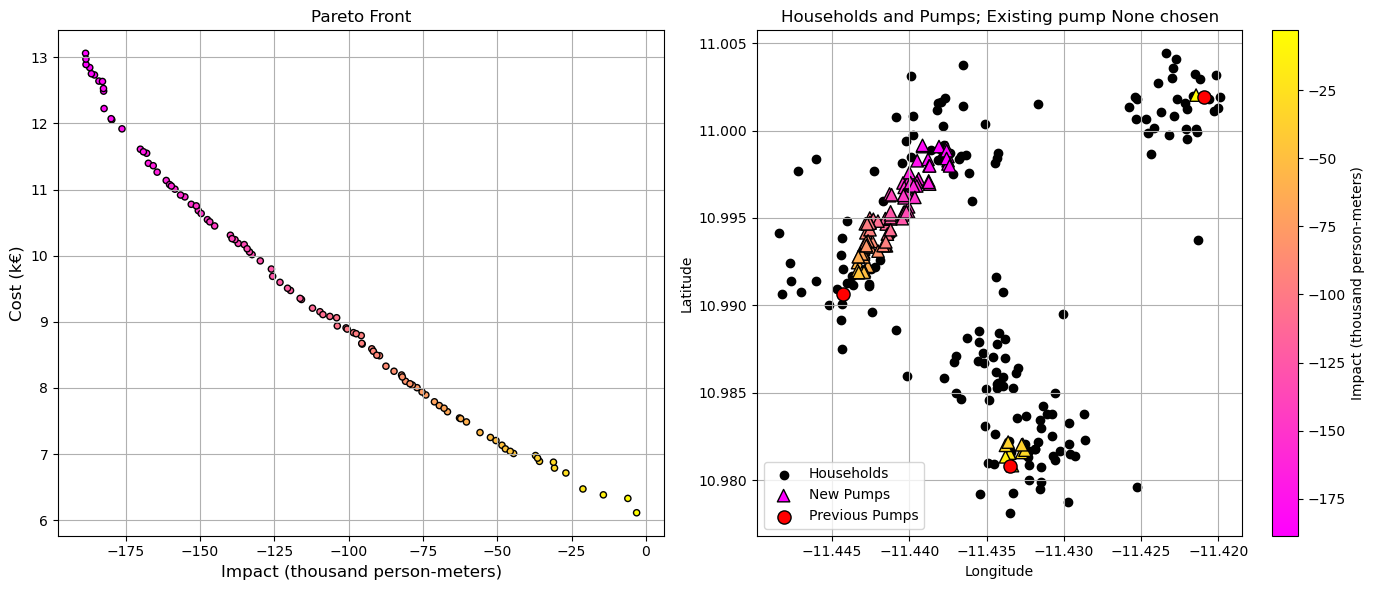

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# === PARETO PLOT (ax1) ===
ax1.scatter(sol_val[:,0]/1000,sol_val[:,1]/1000,c = sol_val[:,0], marker='o', s=20, cmap='spring', edgecolor='k')
ax1.set_xlabel('Impact (thousand person-meters)', fontsize=12)
ax1.set_ylabel('Cost (k€)', fontsize=12)
ax1.set_title('Pareto Front', fontsize=12)
ax1.grid(True)

# === GEOGRAPHICAL PLOT (ax2) ===

# Plot households (black dots)
ax2.scatter(households['Lon'], households['Lat'], color='black', label='Households')

# Plot new pumps, colored by first objective value
sc = ax2.scatter(
    pos_pumps_new[:, 0], pos_pumps_new[:, 1],
    c=sol_val[:, 0]/1000,
    cmap='spring', 
    edgecolor='k',
    s=80,
    label='New Pumps',
    marker='^'
)

# Plot previous pumps (red)
ax2.scatter(pos_pumps[:, 0], pos_pumps[:, 1], color='red', label='Previous Pumps', edgecolors='k', s=90)

# Add colorbar
cbar = fig.colorbar(sc, ax=ax2)
cbar.set_label('Impact (thousand person-meters)')

# Labels and title
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title(f'Households and Pumps; Existing pump {pump_specified} chosen')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [38]:
# Find consumption at each standpipe for each possible solution

pos_pumps_with_new = np.array([np.concatenate((pos_pumps,[pump]), axis=0) for j, pump in enumerate(sol_pos)])

pump_index_min = np.zeros((len(pos_pumps_with_new),len(pos_households)))
for i,household in enumerate(pos_households):
    for x in range(len(pos_pumps_with_new)):
        pump_distances = np.zeros(len(pos_pumps_with_new[x]))
        for k, pump in enumerate(pos_pumps_with_new[x]):
            pump_distances[k] = geo.great_circle(household, pump).meters
        pump_index_min[x,i] = np.argmin(pump_distances)


# Initialize consumption_pump to store the total consumption for each pump
consumption_pump = np.zeros((len(pos_pumps_with_new), len(pos_pumps) + 1))  # +1 for the new pump in each solution

# Update consumption_pump based on the closest pump
for x in range(len(pos_pumps_with_new)):  # Iterate over solutions
    for i, household in households.iterrows():  # Iterate over households
        closest_pump_index = int(pump_index_min[x, i])  # Closest pump index
        consumption_pump[x, closest_pump_index] += household['Nb capita'] * consumption_person

# for x in range(len(pos_pumps_with_new)):
#      for n_pumps in range(len(pos_pumps)):
#         consumption_pump[x,sol_pumps[x]] += consumption_pump[x,len(pos_pumps)]  # Add consumption from the new pump to the closest existing pump
#      consumption_pump[x, ]
# consumption_pump[:, ]        
#         if closest_pump_index == 3:
#             consumption_pump[x,sol_pumps[x]] += household['Nb capita'] * consumption_person  # Add consumption from the new pump to the closest existing pump

for x in range(len(pos_pumps_with_new)):  # Iterate over solutions
   consumption_pump[x, sol_pumps[x]] += consumption_pump[x, -1]  # Add consumption from the new pump to the closest existing pump
    

In [39]:
# Debugging checks
# print(sol_pumps)
# print(consumption_pump[0,sol_pumps[0]]+consumption_pump[0,-1],baseline_consumption[0],consumption_pump[0,0])
# for i, household in households.iterrows():
#     if -11.435<=household['Lon']<=-11.43 and 10.99<=household['Lat']<=10.995:
#         print(household)

# print(pump_index_min[:, 145])


C:\Users\angus\AppData\Local\Temp\ipykernel_16604\2039077861.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


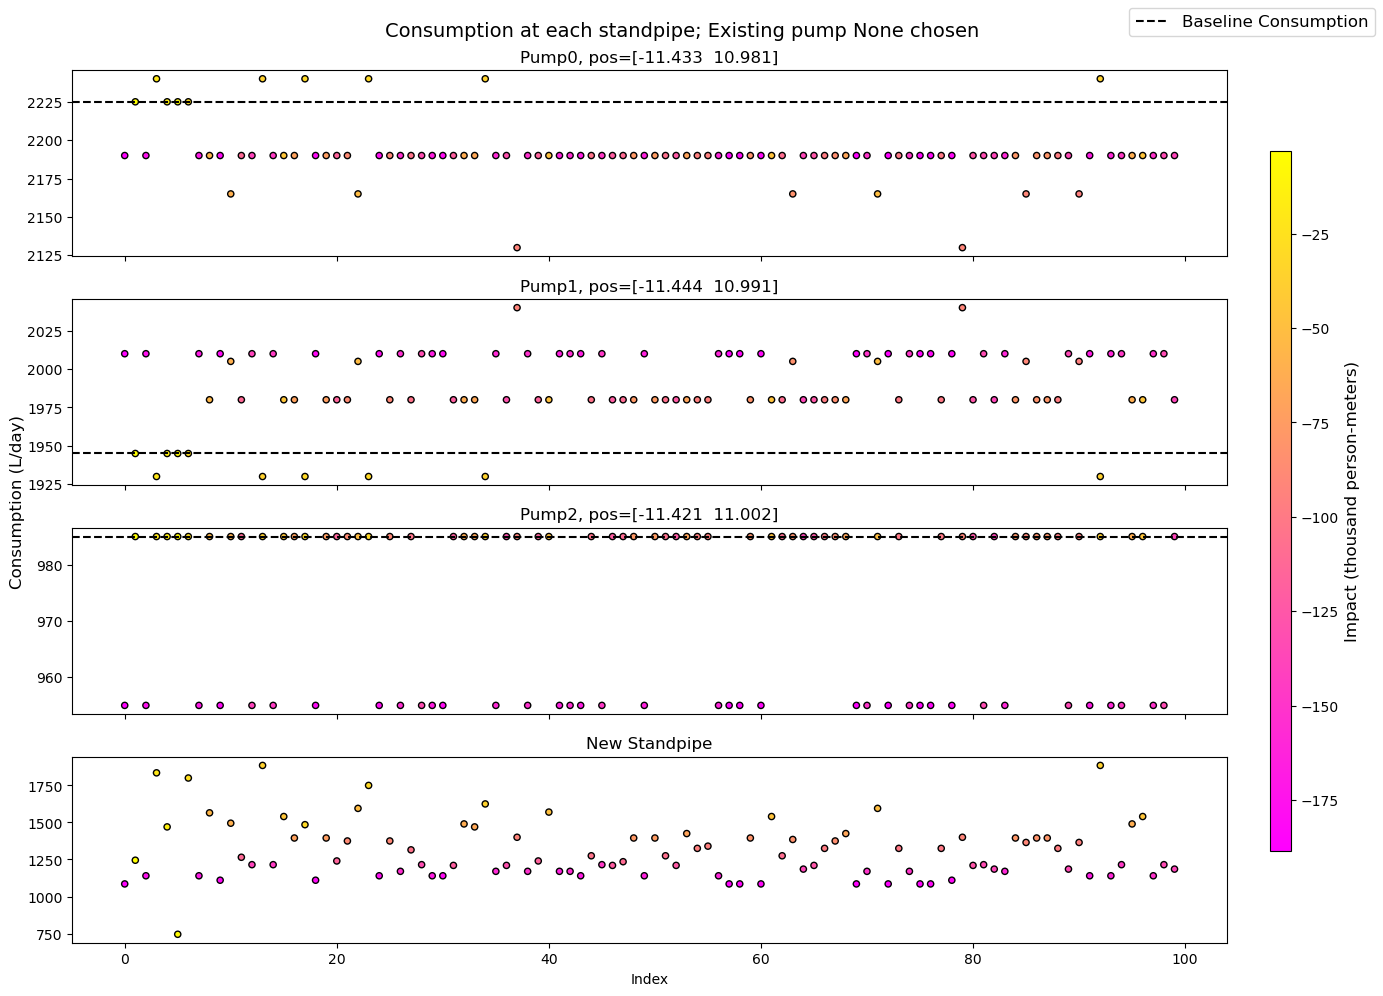

In [ ]:
indices = np.arange(len(pos_pumps_with_new))
# Plotting the consumption at each standpipe using matplotlib
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

titles = [
    f'Pump0, pos={np.round(pos_pumps[0], 3)}',
    f'Pump1, pos={np.round(pos_pumps[1], 3)}',
    f'Pump2, pos={np.round(pos_pumps[2], 3)}',
    'New Standpipe'
]

# Use a consistent colormap
cmap = 'spring' 

for i in range(4):
    if i != 3:
        axs[i].axhline(y=baseline_consumption[i], color='black', linestyle='--', label='Baseline Consumption')
    sc = axs[i].scatter(
        indices,
        consumption_pump[:, i],
        c=sol_val[:, 0]/1000,
        cmap=cmap,
        s=20,
        edgecolor='k'
    )
    
    axs[i].set_title(titles[i])

axs[-1].set_xlabel("Index")
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(sc, cax=cbar_ax).set_label(label='Impact (thousand person-meters)', fontsize=12)
fig.suptitle(f"Consumption at each standpipe; Existing pump {pump_specified} chosen", fontsize=14)
fig.supylabel("Consumption (L/day)", fontsize=12)
legend_handles = plt.Line2D([0], [0],color='black',label='Baseline Consumption', linestyle='--')
fig.legend(handles=[legend_handles], loc='upper right', fontsize=12)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
